In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [26]:
import numpy as np
import pandas as pd

In [27]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import sqlite3

In [29]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [31]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [32]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [33]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [34]:
columns2 = inspector.get_columns('station')
for c in columns2:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [35]:
for row in session.query(Measurement.date, Measurement.prcp).limit(15).all():
    print(row)

('2010-01-01', 0.08)
('2010-01-02', 0.0)
('2010-01-03', 0.0)
('2010-01-04', 0.0)
('2010-01-06', None)
('2010-01-07', 0.06)
('2010-01-08', 0.0)
('2010-01-09', 0.0)
('2010-01-10', 0.0)
('2010-01-11', 0.01)
('2010-01-12', 0.0)
('2010-01-14', 0.0)
('2010-01-15', 0.0)
('2010-01-16', 0.0)
('2010-01-17', 0.0)


# Exploratory Climate Analysis

SELECT strftime(?, measurement.date) AS strftime_1 
FROM measurement ORDER BY measurement.date DESC
('2017-08-23',)
2016-08-23


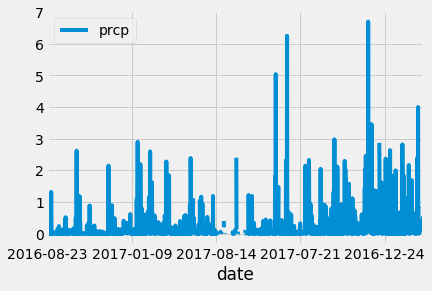

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
recent = session.query(func.strftime('%Y-%m-%d', Measurement.date)).order_by(Measurement.date.desc())
print(recent)

# Calculate the date 1 year ago from the last data point in the database
last_datapoint = recent.first()
print(last_datapoint)

year_prior = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_prior)

# Perform a query to retrieve the data and precipitation scores

last_12 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_prior)

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(last_12, columns=['date', 'prcp'])

df.set_index('date', inplace=True)
df.head()
# Sort the dataframe by date
df.sort_values(by=['date'])
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()

plt.show()

![precipitation](Images/precipitation.png)

In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [38]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).group_by(Station.name).count()
print(f"There are {stations} stations")

There are 9 stations


In [39]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [40]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]

station_stats = session.query(*sel).filter(Measurement.station == 'USC00519281').all()
station_stats

[(54.0, 85.0, 71.66378066378067)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A2BDBCC2B0>]],
      dtype=object)

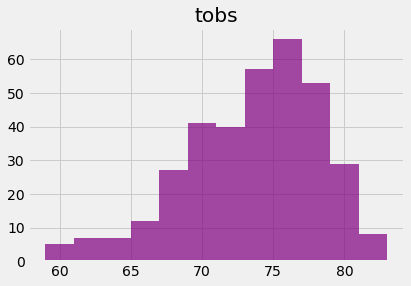

In [50]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stationx = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= year_prior).all()
stationx
stationx_df = pd.DataFrame(stationx, columns=['tobs'])
stationx_counts = stationx_df['tobs']
df_counts = pd.DataFrame(stationx_counts)
df_counts.head()
df_counts.hist(bins=12, color="purple", alpha=.7)

In [42]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram



![precipitation](Images/station-histogram.png)

In [125]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-06-06', '2018-05-05'))

[(69.0, 78.05168539325842, 87.0)]


In [44]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-05-20', '2017-05-27'))
tmin, taverage, tmax = calc_temps('2017-05-20', '2017-05-27')[0]

[(69.0, 74.97826086956522, 87.0)]


<bound method Figure.show of <Figure size 288x576 with 1 Axes>>

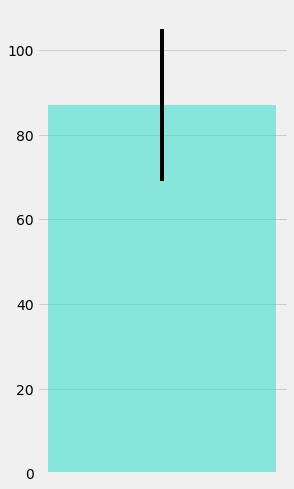

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize = plt.figaspect(2))
x = 1
yerr = (tmax - tmin)
bar = ax.bar(x, tmax, yerr=yerr, color="turquoise", alpha=.6, align="center")
ax.set(xticks=range(x))
fig.show

In [67]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.prcp, Measurement.date, Measurement.station, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
trip_data = session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= '2017-06-06').filter(Measurement.date < '2017-06-16').all()

trip_df = pd.DataFrame(trip_data)
trip_df.sort_values('prcp')
trip_df.head(20)

,prcp,date,station,station,name,latitude,longitude,elevation
0,0.00,2017-06-06,USC00519397,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,0.00,2017-06-07,USC00519397,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,0.00,2017-06-08,USC00519397,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,0.00,2017-06-09,USC00519397,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,0.04,2017-06-10,USC00519397,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
5,0.08,2017-06-11,USC00519397,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
6,0.02,2017-06-12,USC00519397,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
7,0.00,2017-06-13,USC00519397,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
8,0.00,2017-06-14,USC00519397,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
9,0.00,2017-06-15,USC00519397,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


## Optional Challenge Assignment

In [121]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [123]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip


# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
dates = ["06-06", "06-07", "06-08", "06-09", "06-10", "06-11", "06-12", "06-13"]
normals = []
for date in dates:
    normal_dict = {}
    normal_dict["tmin"] = tmin
    normal_dict["taverage"] = taverage
    normal_dict["tmax"] = tmax
    normals.append(normal_dict)

normals

[{'tmin': 70.0, 'taverage': 75.17543859649123, 'tmax': 80.0},
 {'tmin': 70.0, 'taverage': 75.17543859649123, 'tmax': 80.0},
 {'tmin': 70.0, 'taverage': 75.17543859649123, 'tmax': 80.0},
 {'tmin': 70.0, 'taverage': 75.17543859649123, 'tmax': 80.0},
 {'tmin': 70.0, 'taverage': 75.17543859649123, 'tmax': 80.0},
 {'tmin': 70.0, 'taverage': 75.17543859649123, 'tmax': 80.0},
 {'tmin': 70.0, 'taverage': 75.17543859649123, 'tmax': 80.0},
 {'tmin': 70.0, 'taverage': 75.17543859649123, 'tmax': 80.0}]

In [116]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normals)
normal_df.head()

,tmin,taverage,tmax
0,70.0,75.175439,80.0
1,70.0,75.175439,80.0
2,70.0,75.175439,80.0
3,70.0,75.175439,80.0
4,70.0,75.175439,80.0


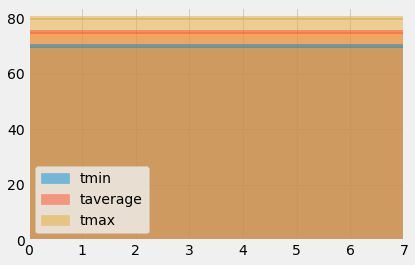

In [117]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot(kind="area", stacked=False)